
# Log Metrics Parser & Plots

It extracts the metric dictionaries associated with `PUZZLES EVAL ... {}` and `EVAL ... {}` lines, aggregates them by step, and plots everything.


In [55]:

import re
import ast
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)


In [56]:

# ==== Configuration ====
# Set the path to your log file here
LOG_PATH = r"\\wsl.localhost\Ubuntu\tmp\train_run.INFO"   

# Optional: if your log uses 'I{MMDD} HH:MM:SS.ssssss' timestamps without year,
# we assume the current year. You can override it here:
ASSUMED_YEAR = datetime.now().year


In [57]:

TIMESTAMP_RE = re.compile(
    r"""
    ^I(?P<mmdd>\d{4})\s+
    (?P<hms>\d{2}:\d{2}:\d{2}\.\d+)\s+
    \d+\s+
    (?P<file>[^\]]+)\]  # e.g., training.py:202]
    """,
    re.VERBOSE,
)

# Matches both "PUZZLES EVAL step=20000 {...}" and "EVAL step=20000 {...}"
EVAL_LINE_RE = re.compile(
    r"""
    (?P<tag>PUZZLES\s+EVAL|EVAL)\s+step=(?P<step>\d+)\s+(?P<dict>\{.*\})\s*$
    """,
    re.VERBOSE,
)

def parse_timestamp(mmdd: str, hms: str, year: int) -> datetime:
    """Convert 'MMDD' + 'HH:MM:SS.ssssss' into a datetime with given year."""
    month = int(mmdd[:2])
    day = int(mmdd[2:])
    # Allow microseconds to be variable length
    if '.' in hms:
        base, frac = hms.split('.')
        # pad/crop microseconds to 6 digits
        frac = (frac + '000000')[:6]
        hms_fixed = f"{base}.{frac}"
    else:
        hms_fixed = f"{hms}.000000"
    return datetime.strptime(f"{year:04d}-{month:02d}-{day:02d} {hms_fixed}", "%Y-%m-%d %H:%M:%S.%f")

def safe_literal_eval(d: str) -> Dict[str, Any]:
    """Safely parse a Python dict literal string (single quotes allowed)."""
    try:
        return ast.literal_eval(d)
    except Exception as e:
        # Try to repair some common issues (e.g., stray trailing commas or malformed floats)
        raise

def parse_log_lines(lines: List[str], assumed_year: int) -> pd.DataFrame:
    """Parse metric lines into a tidy DataFrame.
    
    Returns columns:
        ['time', 'file', 'tag', 'step', 'metric', 'value']
    where tag in {'EVAL', 'PUZZLES EVAL'}.
    """
    records: List[Dict[str, Any]] = []
    for line in lines:
        ts_m = TIMESTAMP_RE.search(line)
        if not ts_m:
            continue
        mmdd = ts_m.group('mmdd')
        hms = ts_m.group('hms')
        file_ctx = ts_m.group('file').rstrip(']')
        when = parse_timestamp(mmdd, hms, assumed_year)

        eval_m = EVAL_LINE_RE.search(line)
        if not eval_m:
            continue

        tag = eval_m.group('tag').replace('\n', '').strip()
        step = int(eval_m.group('step'))
        dct_str = eval_m.group('dict')

        # Parse the metric dict
        mdict = safe_literal_eval(dct_str)
        if not isinstance(mdict, dict):
            continue

        for k, v in mdict.items():
            try:
                val = float(v)
            except Exception:
                # Skip non-numeric entries
                continue
            records.append({
                'time': when,
                'file': file_ctx,
                'tag': tag,
                'step': step,
                'metric': k,
                'value': val,
            })

    if not records:
        return pd.DataFrame(columns=['time','file','tag','step','metric','value'])

    df = pd.DataFrame.from_records(records)
    df.sort_values(['step', 'time', 'metric'], inplace=True, ignore_index=True)
    return df

def pivot_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Pivot to wide format: one row per (tag, step), columns per metric."""
    if df.empty:
        return pd.DataFrame()
    wide = df.pivot_table(index=['tag', 'step'], columns='metric', values='value', aggfunc='last').reset_index()
    # Flatten columns
    wide.columns.name = None
    return wide


In [58]:
from pathlib import Path
import subprocess


def read_lines_best_effort(unc_path: str):
    # 1) Try normal Windows UNC
    p = Path(unc_path)
    try:
        with p.open("r", encoding="utf-8", errors="ignore") as f:
            return f.readlines()
    except OSError as e:
        last_err = e

    # 2) Try Windows “extended UNC” prefix
    #    \\?\UNC\wsl.localhost\Ubuntu\tmp\train_run.INFO
    ext_unc = r"\\?\UNC" + unc_path.lstrip("\\")
    p2 = Path(ext_unc)
    try:
        with p2.open("r", encoding="utf-8", errors="ignore") as f:
            return f.readlines()
    except OSError as e:
        last_err = e

    # 3) Fallback: read via WSL (convert \\wsl.localhost\Ubuntu\... -> /tmp/...)
    parts = unc_path.split("\\")
    # Example split: ["", "", "wsl.localhost", "Ubuntu", "tmp", "train_run.INFO"]
    if len(parts) >= 5:
        linux_path = "/" + "/".join(parts[4:])  # -> "/tmp/train_run.INFO"
        try:
            text = subprocess.check_output(["wsl.exe", "cat", linux_path],
                                           text=True, encoding="utf-8", errors="ignore")
            return text.splitlines(True)
        except Exception as e:
            last_err = e

    raise last_err

# ==== Load & Parse ====
try:
    lines = read_lines_best_effort(LOG_PATH)
    df_long = parse_log_lines(lines, ASSUMED_YEAR)

    df_wide = pivot_metrics(df_long)
except Exception as e:
    print(f"Failed to read log via UNC/extended UNC/WSL. Error: {e}")


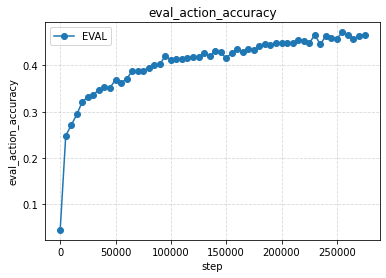

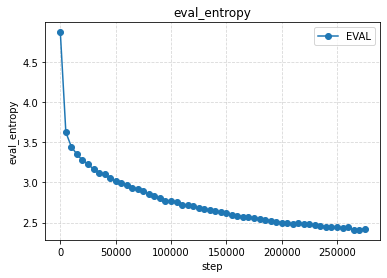

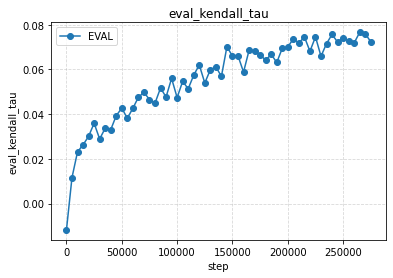

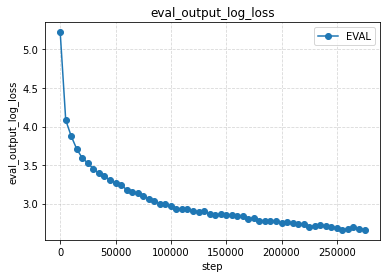

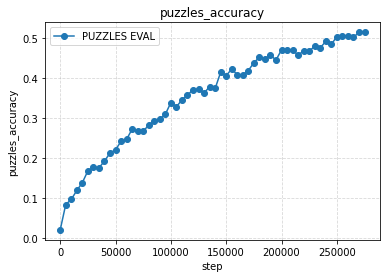

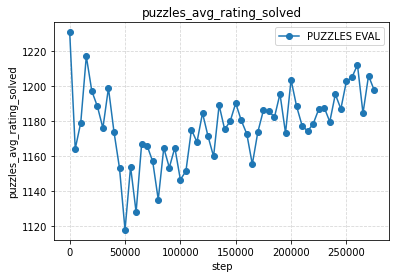

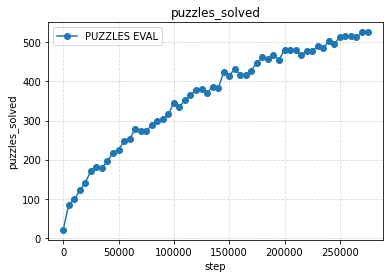

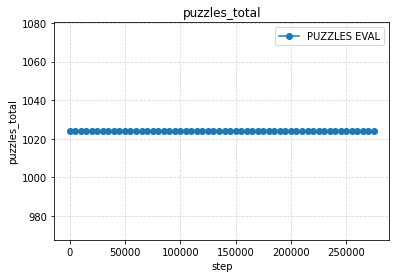

In [59]:

# ==== Plotting ====
# We will create one plot per metric, over 'step'.
# If both 'EVAL' and 'PUZZLES EVAL' are present, they will appear as separate series.
if 'df_long' in globals() and not df_long.empty:
    for metric_name, group in df_long.groupby('metric'):
        plt.figure()
        for tag, sub in group.groupby('tag'):
            sub_sorted = sub.sort_values('step')
            plt.plot(sub_sorted['step'], sub_sorted['value'], marker='o', label=tag)
        plt.title(metric_name)
        plt.xlabel('step')
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
else:
    print("No metric lines found to plot. Check your LOG_PATH or parsing patterns.")


In [60]:

# ==== Optional: Save parsed data to CSV ====
if 'df_long' in globals() and not df_long.empty:
    out_long = 'metrics_long.csv'
    out_wide = 'metrics_wide.csv'
    df_long.to_csv(out_long, index=False)
    if 'df_wide' in globals() and not df_wide.empty:
        df_wide.to_csv(out_wide, index=False)
    print(f"Saved: {out_long}")
    if 'df_wide' in globals() and not df_wide.empty:
        print(f"Saved: {out_wide}")


Saved: metrics_long.csv
Saved: metrics_wide.csv
